<a href="https://colab.research.google.com/github/stsan9/EndoMondoResearchERSP/blob/master/Endo_Data_Vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Set Up

In [0]:
import pandas as pd
import json
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
rootpath = '/content/gdrive/My Drive/Group Research Materials/McAuley/truncatedData.json'
properPath = '/content/gdrive/My Drive/EndoMondoData/endomondoHR_proper.json'

In [0]:
data = []
with open(properPath) as f:
    for l in f:
        data.append(eval(l))

In [0]:
dataframe = pd.DataFrame.from_dict(data)

# Data Processing

In [0]:
def begin(l):
  """Replaces the series of timestamps with the starting one."""
  if isinstance(l, list):
    return l[0]

In [0]:
df = dataframe.copy()

#one-hot encodes gender 
df = pd.concat([df,pd.get_dummies(df['gender'], prefix='gender')],axis=1)
df.drop(['gender'],axis=1, inplace=True)

#one-hot encodes sport
df = pd.concat([df,pd.get_dummies(df['sport'], prefix='sport')],axis=1)
df.drop(['sport'],axis=1, inplace=True)


# converts timestamp list to the first values and heart_rate list to the average
df['timestamp'] = df['timestamp'].apply(begin)
df['heart_rate'] = df['heart_rate'].apply(np.mean)
df = df.sort_values(by=['userId']).drop(['altitude', 'latitude', 'longitude', 'url', 'speed'], axis=1)
df

,heart_rate,id,userId,timestamp,gender_female,gender_male,gender_unknown,sport_bike,sport_bike (transport),sport_core stability training,sport_hiking,sport_kayaking,sport_mountain bike,sport_orienteering,sport_rowing,sport_run,sport_tennis
415,142.075472,370007374,279317,1403554148,1,0,0,0,0,0,0,0,0,0,1,0,0
433,146.012000,341325829,279317,1400349969,1,0,0,0,0,0,0,0,0,0,0,1,0
434,121.867735,341336159,279317,1400244493,1,0,0,1,0,0,0,0,0,0,0,0,0
435,141.582000,341335636,279317,1400238345,1,0,0,0,0,0,0,0,0,0,1,0,0
437,137.341463,341334720,279317,1400173297,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,136.934000,326001812,11889307,1395585050,0,0,1,1,0,0,0,0,0,0,0,0,0
684,149.520000,326001947,11889307,1394992925,0,0,1,1,0,0,0,0,0,0,0,0,0
685,131.944000,326002008,11889307,1394987209,0,0,1,1,0,0,0,0,0,0,0,0,0
687,152.422000,326002154,11889307,1394375394,0,0,1,1,0,0,0,0,0,0,0,0,0


# Data Visualization

In [0]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_color_codes()
import matplotlib.pyplot as plt

[Text(0.5, 0, 'Number of Workouts')]

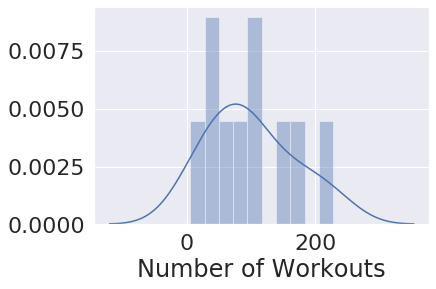

In [0]:
#Historgram of the number of workouts per user
gen = sns.distplot(dataframe.groupby('userId').count()['heart_rate'], bins=10)
gen.set(xlabel='Number of Workouts')

[Text(0.5, 0, 'Average Heart Rate per User')]

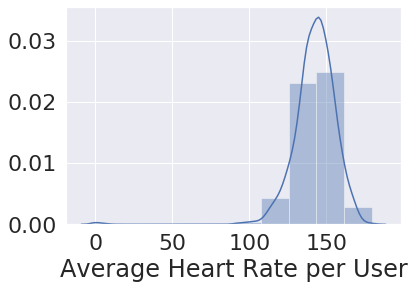

In [0]:
#Average heartrate per user
ave_hr = sns.distplot(dataframe.groupby('userId').mean()['heart_rate'], bins=10)
ave_hr.set(xlabel='Average Heart Rate per User')

Number of Invalid Heart Rate Values: 486
Number of Unreliable Users: 15


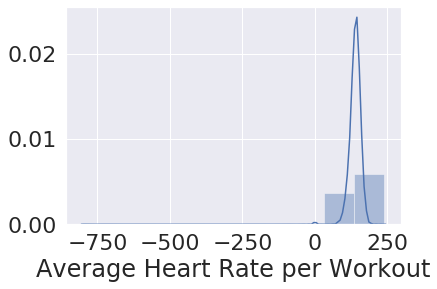

In [0]:
#All workout heartrates
gen_hr = sns.distplot(dataframe['heart_rate'], bins=10)
gen_hr.set(xlabel='Average Heart Rate per Workout')

#It seems there is data that doesn't make sense still present in the data set
print('Number of Invalid Heart Rate Values: ' + str(dataframe[dataframe['heart_rate']<=40 and dataframe['heart_rate']>=200].shape[0]))
print('Number of Unreliable Users: ' + str(dataframe[dataframe['heart_rate']<=30 and dataframe['heart_rate']>=200].groupby('userId').count().shape[0]))

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


[Text(0.5, 0, 'STD of Average Heart rates per User')]

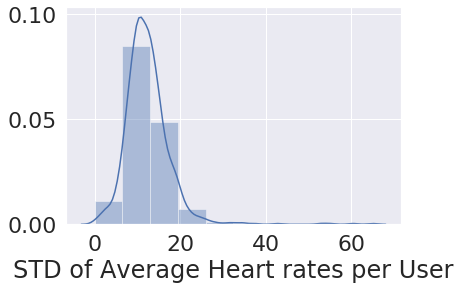

In [0]:
#STD for workout heartrates per user
user_std = sns.distplot(dataframe.groupby('userId').std()['heart_rate'], bins=10)
user_std.set(xlabel='STD of Average Heart rates per Workout per User')

In [0]:
df = dataframe.copy().sample(n=15, random_state=1).drop(axis = 1, columns=['speed', 'altitude', 'gender', 'url', 'longitude', 'latitude'])
lst_col = 'heart_rate'

time_group = pd.DataFrame({
      col:np.repeat(df[col].values, df[lst_col].str.len())
      for col in df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns]

In [0]:
def time_to_percent(times):
  start = times[0]
  total = times[-1] - start
  times[0] = 0

  for i in range(1, len(times)):
    times[i] = (times[i] - start) / total
  return times

timestamps = []
for x in range(df.shape[0]):
  timestamps += time_to_percent(df.iloc[x]['timestamp'])

time_group['timestamp'] = timestamps

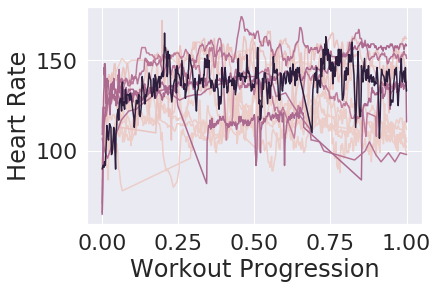

In [0]:
user_lineplot = sns.lineplot(x='timestamp', y='heart_rate', hue="userId",
                             units='id', estimator=None, legend=False, 
                             data=time_group)
user_lineplot.set(xlabel='Workout Progression', ylabel='Heart Rate')
plt.show()

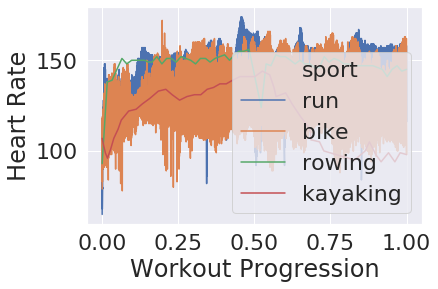

In [0]:
user_lineplot = sns.lineplot(x='timestamp', y='heart_rate', hue="sport",
                            units='sport', estimator=None, data=time_group)
user_lineplot.set(xlabel='Workout Progression', ylabel='Heart Rate')
plt.show()

In [0]:
# function to extract first element of each list "l"
def begin(l):
    if isinstance(l, list):
        return l[0]

# function to get the mean of only the middle 300 / 500 timestamps in one workout
def mean(l):
    return np.mean(l[100:-100])

In [0]:
dataframe['heart_rate'] = dataframe['heart_rate'].apply(mean)
dataframe['timestamp'] = dataframe['timestamp'].apply(begin)

dataframe = dataframe.drop(columns = ["longitude", "altitude", "latitude", "speed", "url", "id", "gender"])
all_users=dataframe["userId"].unique()

for user in all_users:
  user_data = dataframe.loc[dataframe["userId"] == user].sort_values("timestamp")
  arr = np.diff(user_data["timestamp"])
  arr=np.append(arr,[0])
  user_data["timestamp"]=arr.tolist()
  indexNames = dataframe[dataframe["userId"] == user].index
  dataframe.drop(indexNames,inplace=True)
  dataframe = dataframe.append(user_data,ignore_index = True)

dataframe = dataframe.rename( columns= { "timestamp" : "hrs_to_next" } )

KeyboardInterrupt: ignored

In [0]:
workout_plc = []
for user_x in all_users:
  workouts = dataframe[dataframe['userId'] == user_x]
  for i in range(workouts.shape[0]):
    workout_plc += [(i + 1)/workouts.shape[0]]
dataframe['workout_placement'] = workout_plc

def time_scale(num):
  return num/60/60
dataframe['hrs_to_next'] = dataframe['hrs_to_next'].apply(time_scale)

In [0]:
bad_users = bad_users = dataframe[dataframe['heart_rate'] < 60]
dataframe = dataframe[~dataframe.userId.isin(bad_users['userId'].unique())]

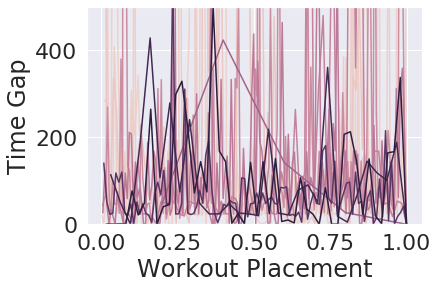

In [0]:
workout_plt = sns.lineplot(x='workout_placement', y='hrs_to_next', hue="userId",
                            units='userId', estimator=None, legend=False, 
                            data=dataframe)
workout_plt.set(xlabel='Workout Placement', ylabel='Time Gap')
workout_plt.set(ylim=(0, 500))
plt.show()

[(0, 250)]

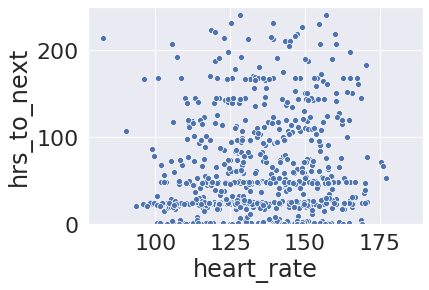

In [0]:
ax = sns.scatterplot(x="heart_rate", y="hrs_to_next", data=dataframe)
ax.set(ylim=(0, 250))

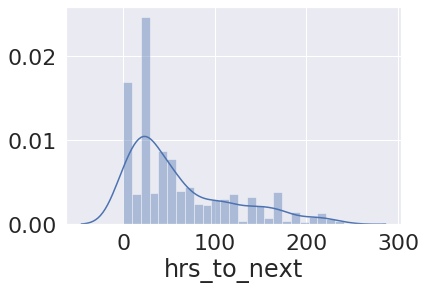

In [0]:
visible_gaps = dataframe[dataframe['hrs_to_next'] < 250]
hr_gaps = sns.distplot(visible_gaps['hrs_to_next'], bins=25)

In [0]:
df = dataframe.copy().groupby("userId").filter(lambda x : len(x) > 40)
error_sq = []
for user in df['userId'].unique():
  user_x = df.loc[dataframe["userId"] == user].sort_values("workout_placement", ascending=False)
  avg_hr = np.average(user_x.iloc[1: 40]['hrs_to_next'])
  error_sq += [(user_x.iloc[0]['hrs_to_next'] - avg_hr) ** 2]
dummy_mse = np.average(error_sq)
dummy_mse

39363.00392882772

# Baseline

In [0]:
df = df.groupby("userId").filter(lambda x : len(x) > 40)

In [0]:
error_sq = []
for user in df['userId'].unique():
  user_x = df.loc[dataframe["userId"] == user].sort_values("timestamp", ascending=False)
  avg_hr = np.average(user_x.iloc[1: 40]['heart_rate'])
  error_sq += [(user_x.iloc[0]['heart_rate'] - avg_hr) ** 2]
dummy_mse = np.average(error_sq)

In [0]:
dummy_mse

65.67677537168032